In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir
from rubin_scheduler.scheduler.utils import EuclidOverlapFootprint

### Evaluating the depth cut for DESC metrics. 

DESC want to identify an area within the LSST to consider as the basis for further study.
The primary goals are: 
* low dust extinction (we'll use E(B-V) < 0.2)
* coverage in at least n filters (we'll use n=6)
* possibly a depth cut in i band depth.

I don't believe the i-band depth cut is super meaningful, so let's take a look at the area that would be returned with and without this cut. 

First, let's just calculate the i-band extragalactic depth at all points over the sky, for the DESC "interesting years" of 1, 4, 7, 10.
(could do this every year but saving brainpower). 

In [14]:
# specify the opsim run to test
opsdb = '../baseline_v3.4_10yrs.db'
run_name = os.path.split(opsdb)[-1].replace('.db', '')

In [15]:
# Basic constraint (removing DDF and near-sun twilight visits)
non_special_visits_constraint = "note not like '%DD%' and note not like '%twi%'"

In [16]:
nside = 64
# If we want to use dust-extinction, the cache should be off
slicer = maf.HealpixSlicer(nside=nside, use_cache=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [17]:
# Let's calculate the extragalactic depth in i band at various years
bundle_dict = {}
metric = maf.ExgalM5()
for year in [1, 4, 7, 10]:
    constraint = non_special_visits_constraint + f" and filter =='i' and night < {year}*365.25"
    # Because that makes ugly dictionary keys and output files .. 
    info_label = f"i band year {year}"
    bundle_dict[year] = maf.MetricBundle(metric, slicer, constraint, run_name=run_name, info_label=info_label)

In [18]:
!mkdir exgal
g = maf.MetricBundleGroup(bundle_dict, opsdb, out_dir='exgal', verbose=True)

mkdir: exgal: File exists


In [19]:
g.run_all()

Querying table None with constraint note not like '%DD%' and note not like '%twi%' and filter =='i' and night < 10*365.25 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter', 'rotSkyPos']
Found 447553 visits
Running:  [10]


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Processing slices: 100%|███████████████| 49152/49152 [00:09<00:00, 5140.39it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint note not like '%DD%' and note not like '%twi%' and filter =='i' and night < 1*365.25 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter', 'rotSkyPos']
Found 50526 visits
Running:  [1]
Processing slices: 100%|███████████████| 49152/49152 [00:06<00:00, 7802.04it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint note not like '%DD%' and note not like '%twi%' and filter =='i' and night < 7*365.25 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter', 'rotSkyPos']
Found 319519 visits
Running:  [7]
Processing slices: 100%|███████████████| 49152/49152 [00:08<00:00, 5573.14it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None w

Let's get a general idea of what the extragalactic m5 depths look like. 

1

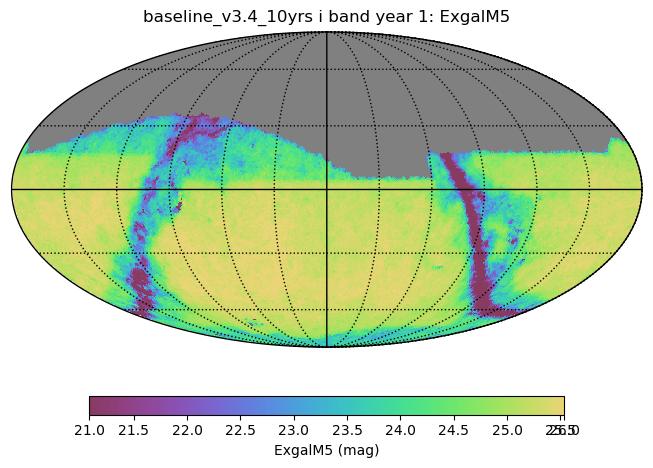

In [25]:
# Make it easier to modify plots
ph = maf.PlotHandler(out_dir='exgal', thumbnail=False, fig_format='png')

ph.set_metric_bundles([bundle_dict[1]])
plot_dict = {'percentile_clip': 95}
ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plot_dict)

Let's also identify the area on the sky which satisfies n_filters=6 and E(B-V) < 0.2. 

In [29]:
class DescCutMetric(maf.BaseMetric):
    def __init__(self, extinction_cut=0.2, n_filters=6, filter_col="filter", units='', **kwargs):
        self.filter_col = filter_col
        self.extinction_cut = extinction_cut
        self.n_filters = n_filters
        # We need the dust map
        maps = ["DustMap"] 
        super().__init__(
            col=[self.filter_col],
            units=units,
            **kwargs,
        )

    def run(self, data_slice, slice_point):
        # exclude areas with high extinction
        if slice_point["ebv"] > self.extinction_cut:
            return self.badval

        # check to make sure there is at least some coverage in the required number of bands
        n_filters = len(np.unique(data_slice[self.filter_col]))
        if n_filters < self.n_filters:
            return self.badval
        # All was good with this point, return '1'
        return 1

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric __main__.DescCutMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))


In [31]:
# Let's calculate the extragalactic depth in i band at various years
cut_bundles = {}
metric = DescCutMetric()
for year in [1, 4, 7, 10]:
    constraint = non_special_visits_constraint + f" and night < {year}*365.25"
    # Because that makes ugly dictionary keys and output files .. 
    info_label = f"i band year {year}"
    cut_bundles[year] = maf.MetricBundle(metric, slicer, constraint, run_name=run_name, info_label=info_label)

In [32]:
g = maf.MetricBundleGroup(cut_bundles, opsdb, out_dir='exgal')
g.run_all()

Let's have a look .. you can see that some points within the footprint are eliminated due to dust extinction - 
the general "WFD" footprint we use for the survey is smoothed somewhat.

1

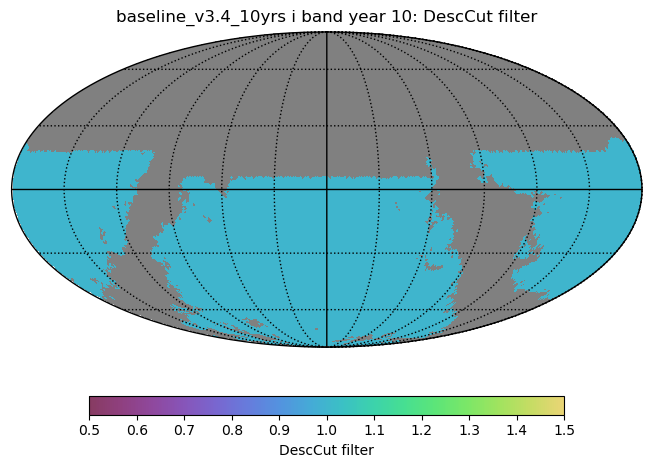

In [35]:
ph.set_metric_bundles([cut_bundles[10]])
plot_dict = {}
ph.plot(plot_func=maf.HealpixSkyMap(), plot_dicts=plot_dict)

Ok, so now let's combine this and the depth maps and see if we're excluding anything meaningful with the typical desc depth cuts.
These cuts were created by scaling the expected depth per year, based on number of images per year. 

In [37]:
offset = 0.1
mag_cuts = {
        1: 24.75 - offset,
        2: 25.12 - offset,
        3: 25.35 - offset,
        4: 25.5 - offset,
        5: 25.62 - offset,
        6: 25.72 - offset,
        7: 25.8 - offset,
        8: 25.87 - offset,
        9: 25.94 - offset,
        10: 26.0 - offset,
    }

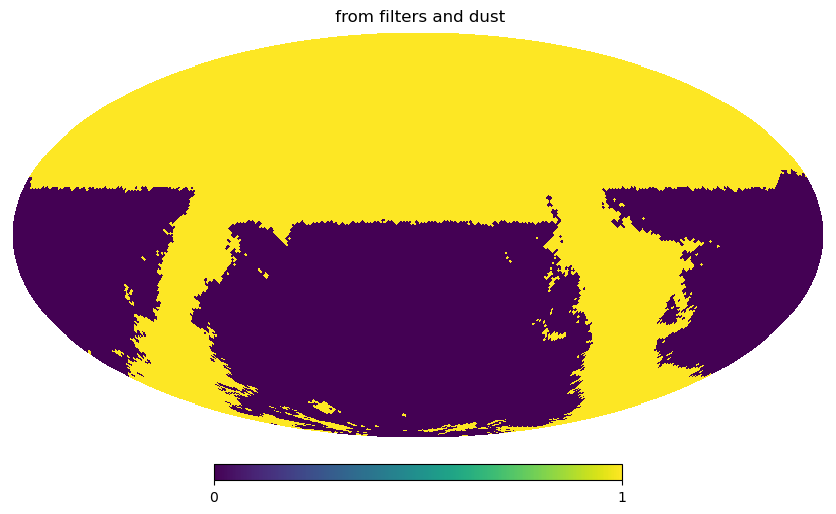

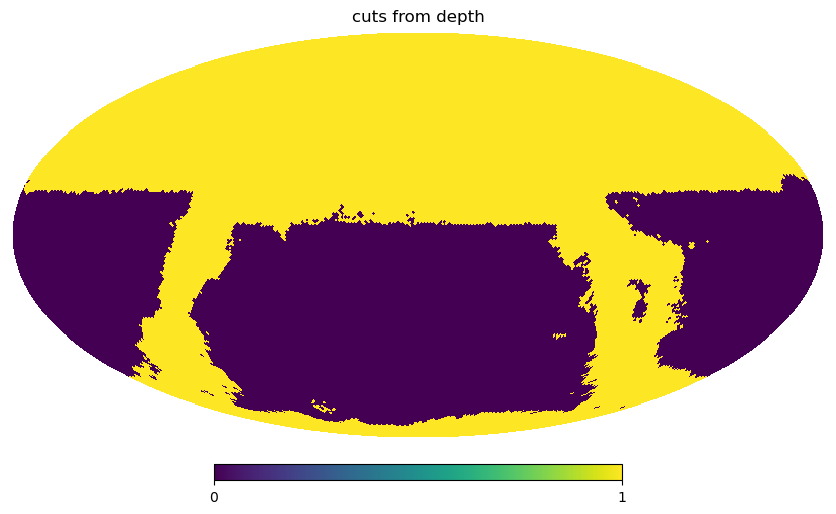

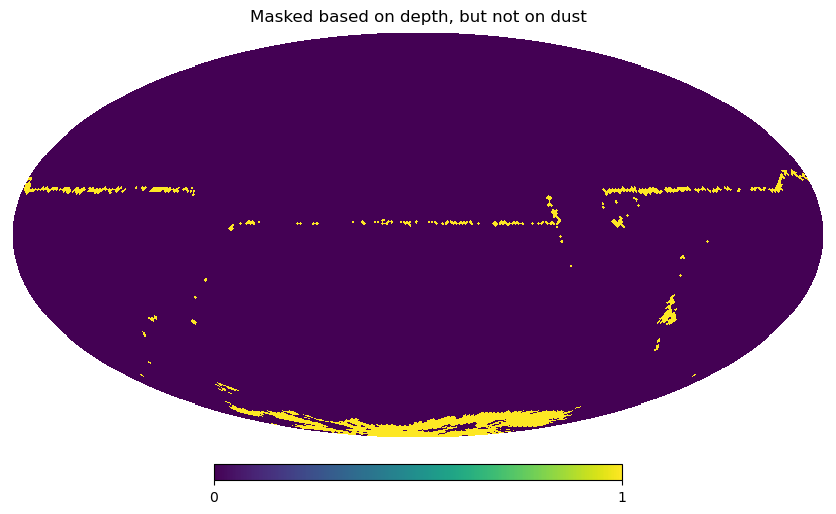

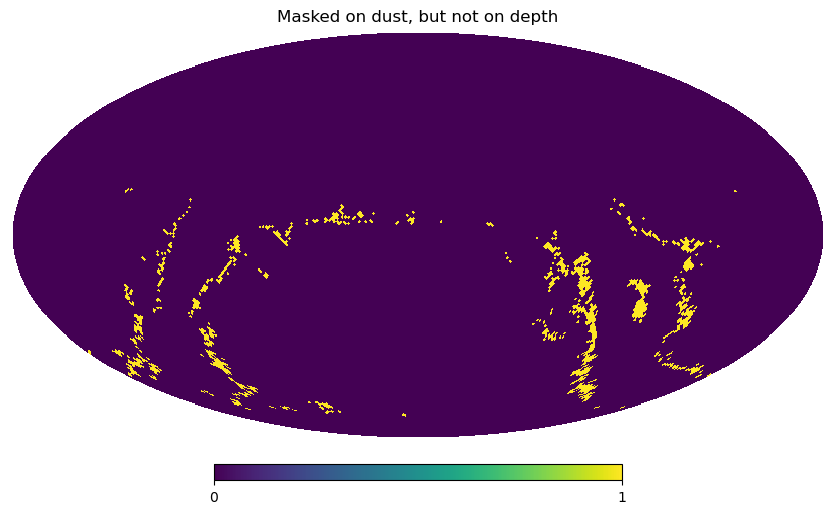

In [62]:
year = 1
# Because we're dealing with the *masks* here .. conceptually let's flip the value
# True = "yes it's masked", False = "no, calculate a metric value"
tmp_dust = cut_bundles[year].metric_values.mask 
hp.mollview(tmp_dust, title=' from filters and dust')
# use the exgal depth to evaluate where this would be "True = masked"
tmp_depth = np.where(bundle_dict[year].metric_values.filled(-999) < mag_cuts[year], True, False)
hp.mollview(tmp_depth, title='cuts from depth')

# Things which were NOT masked due to filters & dust, but WERE masked due to depth
tmp_diff1 = np.where(tmp_depth & ~tmp_dust, True, False)
hp.mollview(tmp_diff1, title='Masked based on depth, but not on dust')

tmp_diff1 = np.where(tmp_dust & ~tmp_depth, True, False)
hp.mollview(tmp_diff1, title='Masked on dust, but not on depth')

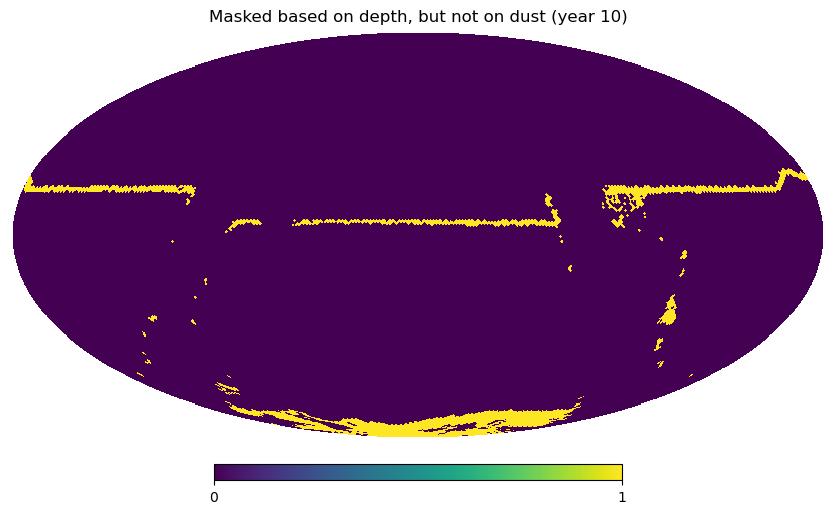

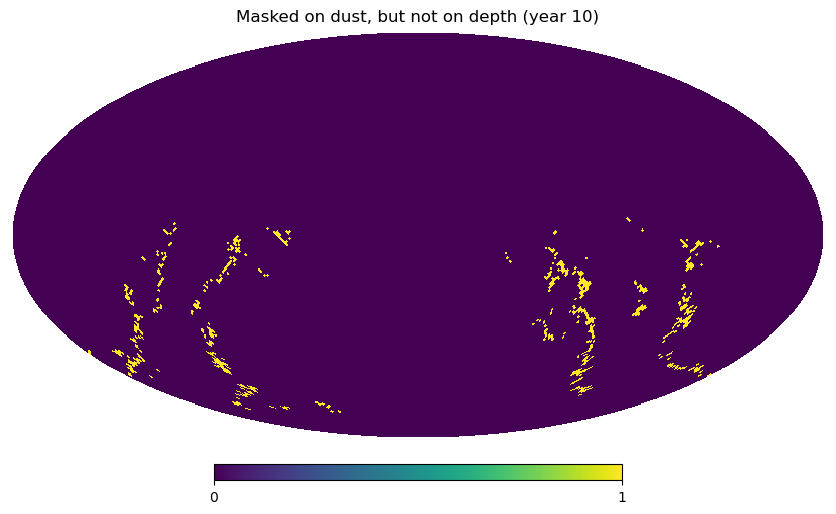

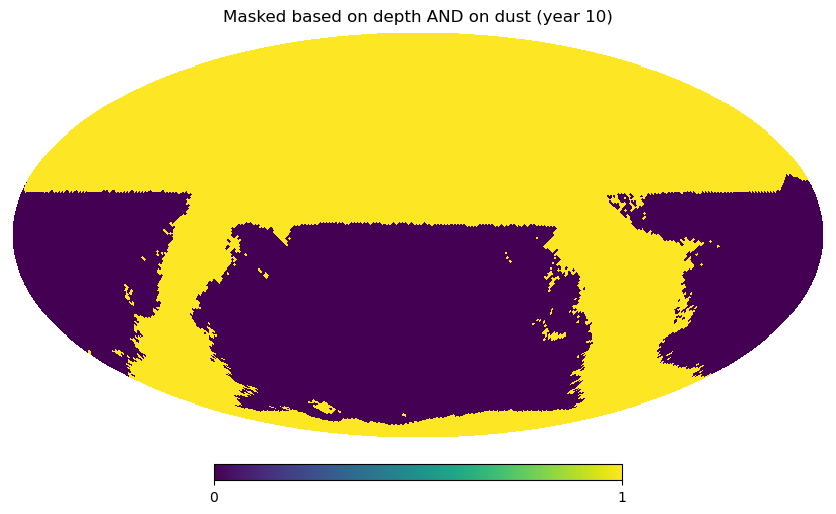

In [77]:
year = 10
# Because we're dealing with the *masks* here .. conceptually let's flip the value
# True = "yes it's masked", False = "no, calculate a metric value"
tmp_dust = cut_bundles[year].metric_values.mask 
#hp.mollview(tmp_dust, title=' from filters and dust')
# use the exgal depth to evaluate where this would be "True = masked"
tmp_depth = np.where(bundle_dict[year].metric_values.filled(-999) < mag_cuts[year], True, False)
#hp.mollview(tmp_depth, title='cuts from depth')

# Things which were NOT masked due to filters & dust, but WERE masked due to depth
tmp_diff1 = np.where(tmp_depth & ~tmp_dust, True, False)
hp.mollview(tmp_diff1, title=f'Masked based on depth, but not on dust (year {year})')

tmp_diff1 = np.where(tmp_dust & ~tmp_depth, True, False)
hp.mollview(tmp_diff1, title=f'Masked on dust, but not on depth (year {year})')

tmp_diff1 = np.where(tmp_depth | tmp_dust, True, False)
hp.mollview(tmp_diff1, title=f'Masked based on depth AND on dust (year {year})')

Clearly there is a problem with using dust + number of filters only .. let's explore some additional options -- using the footprint definitions from the scheduler.

['' 'LMC_SMC' 'bulgy' 'dusty_plane' 'euclid_overlap' 'lowdust' 'nes' 'scp'
 'virgo']


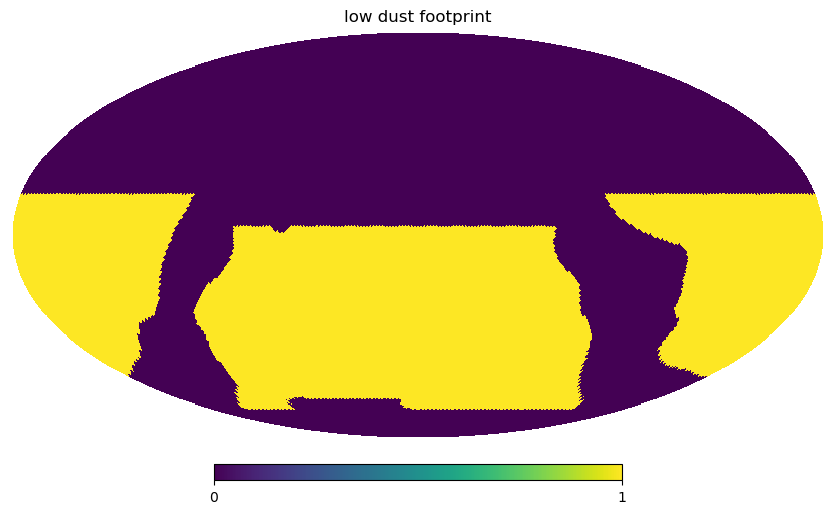

In [80]:
skyarea = EuclidOverlapFootprint(nside=nside)
footprints, labels = skyarea.return_maps()
print(np.unique(labels))
low_dust_fp = np.where(labels == 'lowdust', True, False)
hp.mollview(low_dust_fp, title='low dust footprint')

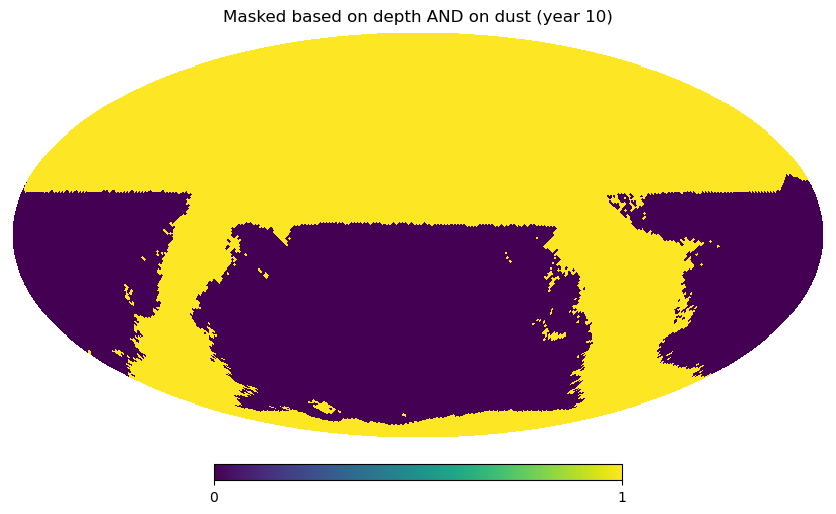

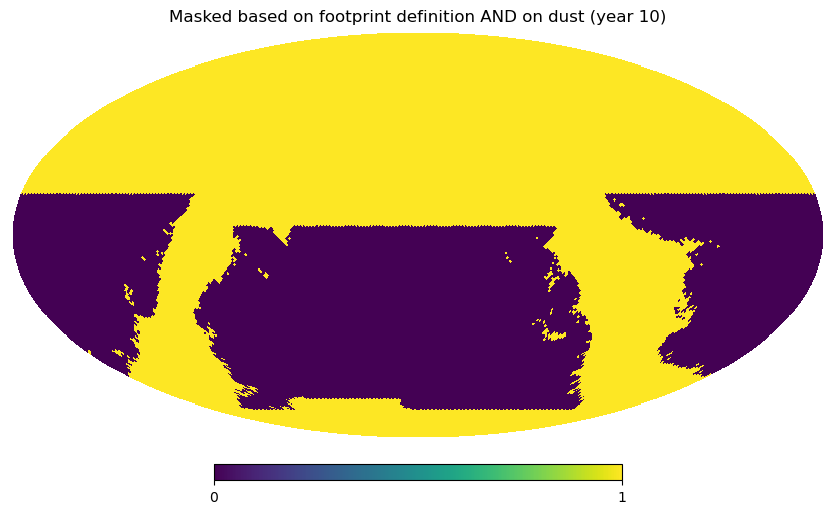

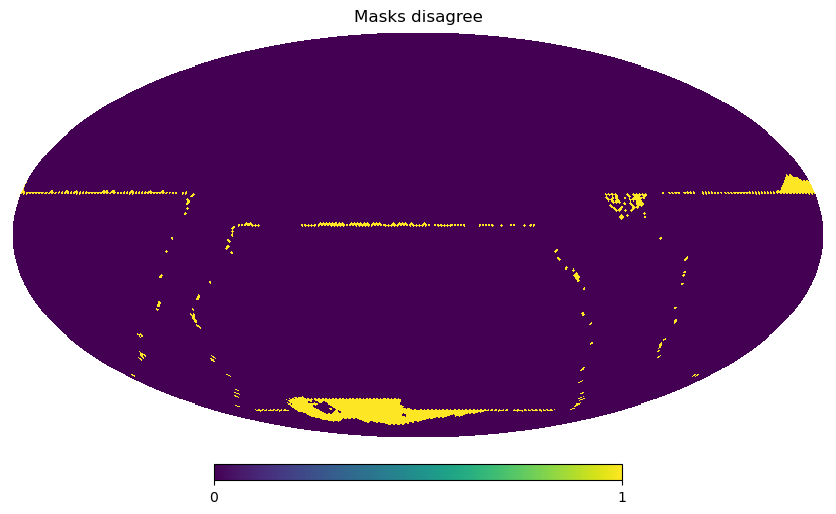

In [84]:
# Ok so let's compare that with the masks above -- 
year = 10

# Because we're dealing with the *masks* here .. conceptually let's flip the value
# True = "yes it's masked", False = "no, calculate a metric value"
tmp_footprint = ~low_dust_fp
#hp.mollview(tmp_footprint)

tmp_dust = cut_bundles[year].metric_values.mask 
#hp.mollview(tmp_dust, title=' from filters and dust')
# use the exgal depth to evaluate where this would be "True = masked"
tmp_depth = np.where(bundle_dict[year].metric_values.filled(-999) < mag_cuts[year], True, False)
#hp.mollview(tmp_depth, title='cuts from depth')

# Things which were NOT masked due to filters & dust, but WERE masked due to depth
tmp_diff1 = np.where(tmp_depth & ~tmp_dust, True, False)
#hp.mollview(tmp_diff1, title=f'Masked based on depth, but not on dust (year {year})')

tmp_diff1 = np.where(tmp_dust & ~tmp_depth, True, False)
#hp.mollview(tmp_diff1, title=f'Masked on dust, but not on depth (year {year})')

tmp_diff1 = np.where(tmp_depth | tmp_dust, True, False)
hp.mollview(tmp_diff1, title=f'Masked based on depth AND on dust (year {year})')

tmp_diff2 = np.where(tmp_dust | tmp_footprint, True, False)
hp.mollview(tmp_diff2, title=f"Masked based on footprint definition AND on dust (year {year})")

tt = np.where(tmp_diff1 ^ tmp_diff2, True, False)
hp.mollview(tt, title=f"Masks disagree")

['' 'LMC_SMC' 'bulgy' 'dusty_plane' 'euclid_overlap' 'lowdust' 'nes' 'scp'
 'virgo']


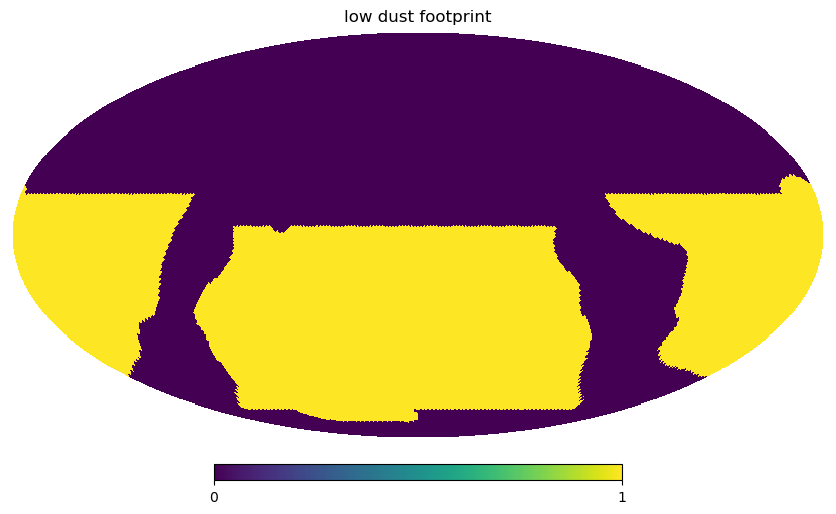

In [88]:
# Check a slightly different definition from the 'footprint' to include LMC_SMC and Virgo 
print(np.unique(labels))
fp = np.where((labels == 'lowdust') | (labels == "LMC_SMC") | (labels == 'virgo') , True, False)
hp.mollview(fp, title='low dust footprint')

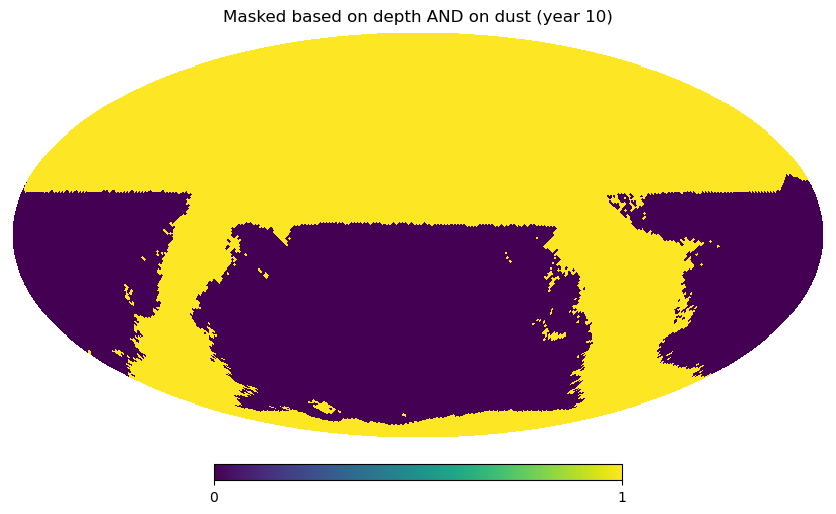

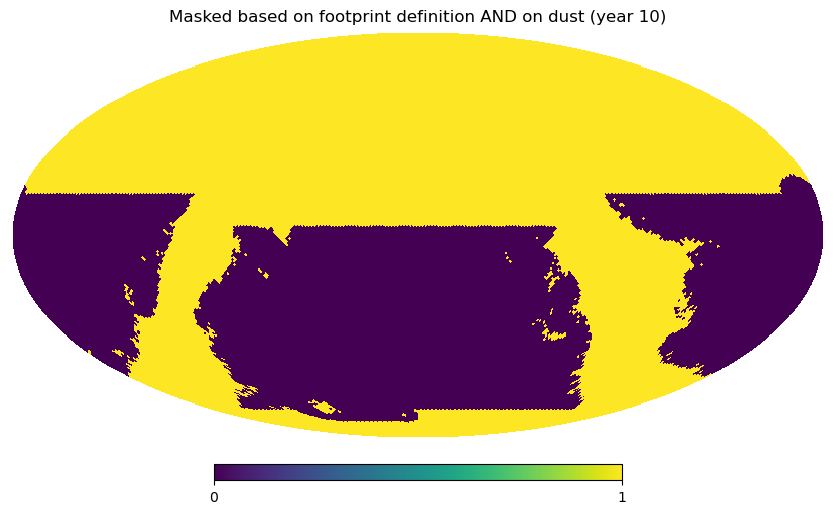

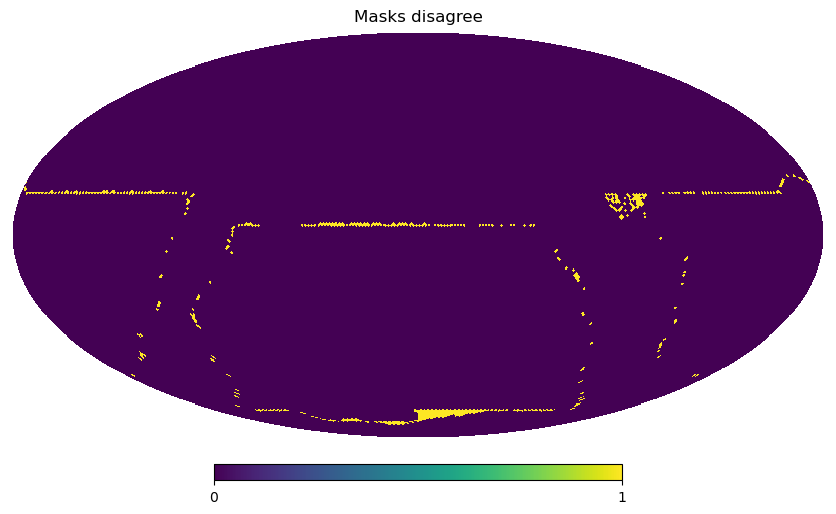

In [89]:
# Ok so let's compare that with the masks above -- 
year = 10

# Because we're dealing with the *masks* here .. conceptually let's flip the value
# True = "yes it's masked", False = "no, calculate a metric value"
tmp_footprint = ~fp
#hp.mollview(tmp_footprint)

tmp_dust = cut_bundles[year].metric_values.mask 
#hp.mollview(tmp_dust, title=' from filters and dust')
# use the exgal depth to evaluate where this would be "True = masked"
tmp_depth = np.where(bundle_dict[year].metric_values.filled(-999) < mag_cuts[year], True, False)
#hp.mollview(tmp_depth, title='cuts from depth')

# Things which were NOT masked due to filters & dust, but WERE masked due to depth
tmp_diff1 = np.where(tmp_depth & ~tmp_dust, True, False)
#hp.mollview(tmp_diff1, title=f'Masked based on depth, but not on dust (year {year})')

tmp_diff1 = np.where(tmp_dust & ~tmp_depth, True, False)
#hp.mollview(tmp_diff1, title=f'Masked on dust, but not on depth (year {year})')

tmp_diff1 = np.where(tmp_depth | tmp_dust, True, False)
hp.mollview(tmp_diff1, title=f'Masked based on depth AND on dust (year {year})')

tmp_diff2 = np.where(tmp_dust | tmp_footprint, True, False)
hp.mollview(tmp_diff2, title=f"Masked based on footprint definition AND on dust (year {year})")

tt = np.where(tmp_diff1 ^ tmp_diff2, True, False)
hp.mollview(tt, title=f"Masks disagree")

In [140]:
class DescCutMetric(maf.BaseMetric):
    def __init__(self, extinction_cut=0.2, n_filters=6, filter_col="filter", units='', **kwargs):
        self.filter_col = filter_col
        self.extinction_cut = extinction_cut
        self.n_filters = n_filters
        # We need the dust map
        maps = ["DustMap"] 
        super().__init__(
            col=[self.filter_col],
            units=units,
            **kwargs,
        )

    def run(self, data_slice, slice_point):
        # exclude areas with high extinction
        if slice_point["ebv"] > self.extinction_cut:
            return self.badval

        # check to make sure there is at least some coverage in the required number of bands
        n_filters = len(np.unique(data_slice[self.filter_col]))
        if n_filters < self.n_filters:
            return self.badval
        # All was good with this point, return '1'
        return 1


class DescDepthAndExposureTimeMetric(maf.BaseMetric):
    """Calculate the extragalactic depth and riz exposure time, incorporating
    DESC cuts, and return these in an array. 

    Parameters
    ----------
    extinction_cut : `float`, optional
        E(B-V) limit. Points above this limit will be rejected.
        Passed to DescCutMetric. 
    n_filters : `int`, optional
        Number of filters required. Points with coverage in fewer filters than this will 
        be rejected. Passed to DescCutMetric.
    min_expTime : `float`, optional
        Minimum exposure time to allow per visit. 
        Passed to RIZDetectionCoaddExposureTime. 
    exgalm5_bandpass : `str`, optional
        Bandpass to calculate the ExgalM5 depth in.
    filter_col : `str`, optional
        The name of the filter column in the data.
    exp_time_col : `str`, optional
        The name of the visit exposure (on sky) time in the data.
    m5_col : `str`, optional
        The name of the 5-sigma limiting depth column in the data.

    Returns
    -------
    metric_value : (`float`, `float`)
        Array of RIZCoaddExposureTime and ExgalM5.

    Notes
    -----
    This metric needs to run with visits in all filters, as the coverage in all
    filters is part of the decision about whether the point on the sky should 
    be considered part of the footprint or not. 
    However, the coadded depth can only be calculated in one bandpass, which is
    `coadded_bandpass`.
    """
    def __init__(self, extinction_cut=0.2, n_filters=6, min_expTime=15, exgalm5_bandpass='i',
                 filter_col="filter", exp_time_col="visitExposureTime", m5_col="fiveSigmaDepth",
                 units='', badval=-666, **kwargs):
        # We do need to track the filter_col here        
        self.filter_col = filter_col
        self.exgalm5_bandpass = exgalm5_bandpass
        # We need the dust map
        maps = ["DustMap"] 
        super().__init__(
            col=[self.filter_col, exp_time_col, m5_col],
            units=units,
            maps=maps,
            metric_dtype="object",
            **kwargs,
        )
        # We want to calculate the coadded exposure time
        self.coadd_exposure_time_metric = maf.RIZDetectionCoaddExposureTime(min_expTime=min_expTime, 
                                                                            ebvlim=extinction_cut,
                                                                            filter_col=filter_col,
                                                                            exp_time_col=exp_time_col,
                                                                            det_bands=["r", "i", "z"],
                                                                            badval=self.badval)
        # We want to calculate the coadded depth (no need for "with cuts" - done elsewhere)
        self.exgal_coadd_metric = maf.ExgalM5(m5_col=m5_col, 
                                              filter_col=filter_col,
                                             badval=self.badval)
        # We want to cut regions of the footprint with high dust or not enough filters
        self.cut_metric = DescCutMetric(extinction_cut=extinction_cut, 
                                        n_filters=n_filters, 
                                        filter_col=filter_col,
                                        badval=self.badval)

    def run(self, data_slice, slice_point):
        # Apply the cuts for dust and n-filters
        dust_and_filters = self.cut_metric.run(data_slice, slice_point)
        if dust_and_filters == self.badval:
            return self.badval
    
        # Calculate the coadd exposure time metric
        coadd_time = self.coadd_exposure_time_metric.run(data_slice, slice_point)

        # Calculate the extragalactic coadded depth
        match = np.where(data_slice[self.filter_col] == self.exgalm5_bandpass)
        coadd_depth = self.exgal_coadd_metric.run(data_slice[match], slice_point)

        return (coadd_time, coadd_depth)

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric __main__.DescCutMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/metrics/base_metric.py:32: UserWarning: Redefining metric __main__.DescDepthAndExposureTimeMetric! (there are >1 metrics with the same name)
  warnings.warn("Redefining metric %s! (there are >1 metrics with the same name)" % (metricname))


In [189]:
# To use the footprint definition along with the dust cuts, along with the constraints ...
nside = 64
skyarea = EuclidOverlapFootprint(nside=nside)
footprints, labels = skyarea.return_maps()
hpids = np.where((labels == 'lowdust') | (labels == "LMC_SMC") | (labels == 'virgo'))[0]

year = 1
no_special_visits_constraint = "note not like '%DD%' and note not like '%twi%'"
constraint = no_special_visits_constraint + f" and night < 365.25*{year}"
info_label = f"year {year}"
slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=hpids, use_cache=False)
metric = DescDepthAndExposureTimeMetric()

bundle = maf.MetricBundle(metric, slicer, constraint, run_name=run_name, info_label=info_label)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [190]:
g = maf.MetricBundleGroup({0: bundle}, opsdb, out_dir='exgal', verbose=True)
g.run_all()

Querying table None with constraint note not like '%DD%' and note not like '%twi%' and night < 365.25*1 for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'visitExposureTime', 'filter', 'rotSkyPos']
Found 220244 visits
Running:  [0]


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Processing slices:  44%|██████▌        | 21468/49152 [00:07<00:09, 2781.67it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [143]:
# So let's look at those metric_values and see how to handle them
bundle.metric_values.compressed()

array([(1230.0, 24.80715154591774), (1560.0, 24.896385024494705),
       (1110.0, 24.64577221721382), ..., (870.0, 24.67754502022471),
       (1620.0, 24.98849764773101), (1530.0, 24.970902396030368)],
      dtype=object)

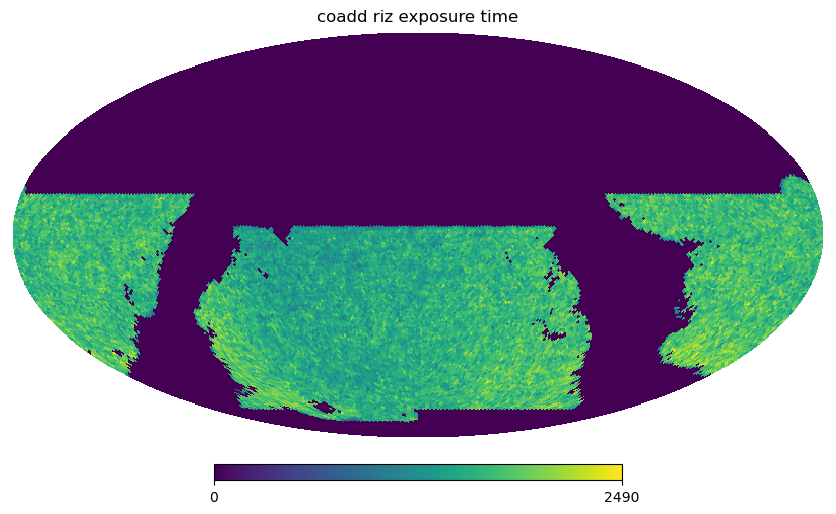

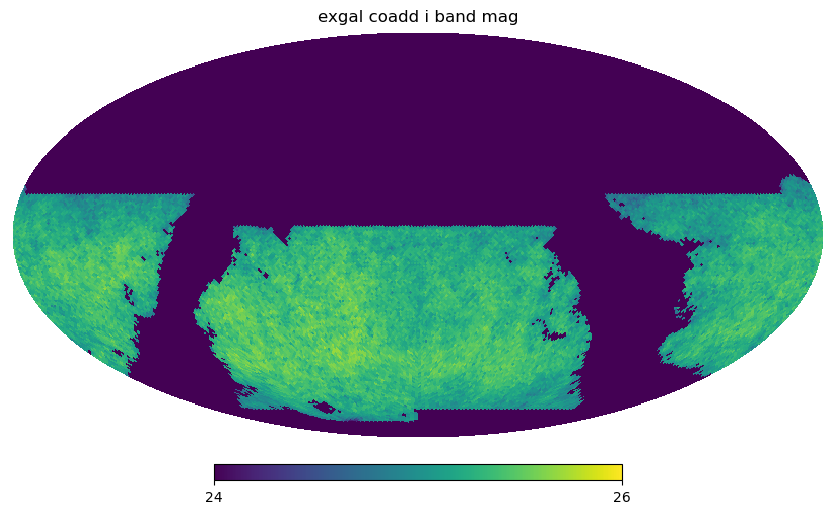

In [188]:
# Pull out the coadded exposure time  .. let's assume you care about keeping the indexes straight
# for stripe identification (??)
# 
coadd_exptime = np.zeros(len(bundle.metric_values))
coadd_depth = np.zeros(len(bundle.metric_values))
idxs = np.where(~bundle.metric_values.mask)
tt = np.vstack([np.array(t) for t in bundle.metric_values[idxs].data])
coadd_exptime[idxs] = tt[:, 0]
coadd_depth[idxs] = tt[:, 1]
hp.mollview(coadd_exptime, title='coadd riz exposure time')
hp.mollview(coadd_depth, title='exgal coadd i band mag', min=24, max=26)


In [191]:
# Let's make a real quick summary metric that works on the outputs from both of these

class TestSummaryMetric(maf.BaseMetric):
    def __init__(self, **kwargs):
        # get whole array passed
        self.mask_val = 0
        super().__init__(col=None, **kwargs)
        self.col = "metricdata"
        
    def run(self, data_slice, slice_point=None):
        # Remember - summary metrics get NONE for the slice_point, but data_slice == metric_values.
        # We can figure out nside from the data_slice/metric_values
        # because we specified "mask_val=0" above
        nside = hp.npix2nside(len(data_slice))
        pix_area = hp.nside2pixarea(nside, degrees=True)

        # Let's consolidate the exposure time and depth into independent arrays
        coadd_exptime = np.zeros(len(data_slice))
        coadd_depth = np.zeros(len(data_slice))
        idxs = np.where(data_slice[self.col] != self.mask_val)
        tt = np.vstack([np.array(t) for t in data_slice[self.col][idxs]])
        coadd_exptime[idxs] = tt[:, 0]
        coadd_depth[idxs] = tt[:, 1]

        footprint_pix = np.where(coadd_exptime > 0)[0]
        footprint_area = len(footprint_pix) * pix_area

        std_depth = np.std(coadd_depth[footprint_pix])
        mean_depth = np.mean(coadd_depth[footprint_pix])

        # format the outputs so that they can be written into the sqlite results db
        result = np.empty(3, dtype=[("name", np.str_, 20), ("value", float)])
        result["name"][0] = "Area"
        result["name"][1] = "Mean Depth"
        result["name"][2] = "Std Depth"

        result["value"][0] = footprint_area
        result["value"][1] = mean_depth
        result["value"][2] = std_depth
        return result                

In [192]:
bundle.set_summary_metrics(TestSummaryMetric())
bundle.compute_summary_stats()

In [193]:
bundle.summary_values

{'TestSummary': array([('Area', 1.74933974e+04), ('Mean Depth', 2.52756404e+01),
        ('Std Depth', 1.68528533e-01)],
       dtype=[('name', '<U20'), ('value', '<f8')])}